# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

from text_classification.fast_text.train import trainIters

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='float32')

Plot the training data

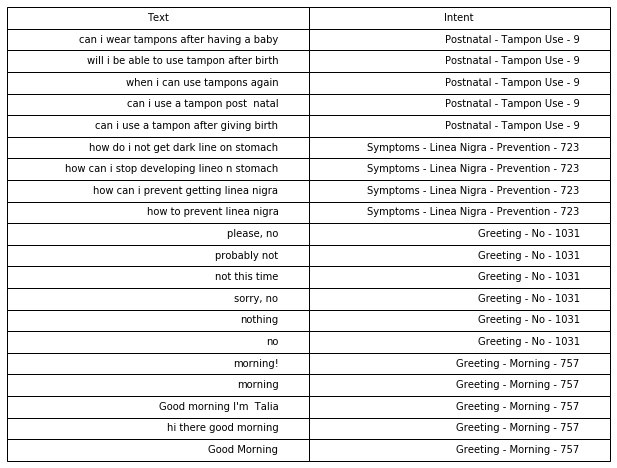

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

In [7]:
import torch
torch.__version__

'0.4.0a0+5463a4a'

Start training the classification model and save

In [8]:
training_data = [(item, y_train[idx]) for idx, item in enumerate(X_train)]

losses, model = trainIters(training_data, 
                           classes, 
                           n_iters=100, 
                           log_every=5, 
                           verbose=1, 
                           learning_rate=1e-3, 
                           batch_size=64)
model.eval()

Training started
Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
0m 29s (- 9m 20s) (5 5%) 0.1150 - accuracy: 0.0000
0m 59s (- 8m 55s) (10 10%) 0.1111 - accuracy: 0.0036
1m 30s (- 8m 34s) (15 15%) 0.0983 - accuracy: 0.0319
1m 57s (- 7m 48s) (20 20%) 0.0788 - accuracy: 0.1376
2m 27s (- 7m 21s) (25 25%) 0.0586 - accuracy: 0.3186
2m 59s (- 6m 57s) (30 30%) 0.0425 - accuracy: 0.4781
3m 29s (- 6m 28s) (35 35%) 0.0312 - accuracy: 0.5987
3m 57s (- 5m 56s) (40 40%) 0.0235 - accuracy: 0.6848
4m 25s (- 5m 24s) (45 45%) 0.0182 - accuracy: 0.7507
4m 51s (- 4m 51s) (50 50%) 0.0144 - accuracy: 0.7998
5m 14s (- 4m 17s) (55 55%) 0.0116 - accuracy: 0.8326
5m 38s (- 3m 45s) (60 60%) 0.0095 - accuracy: 0.8618
6m 2s (- 3m 15s) (65 65%) 0.0080 - accuracy: 0.8799
6m 26s (- 2m 45s) (70 70%) 0.0068 - accuracy: 0.8939
6m 50s (- 2m 16s) (75 75%) 0.0059 - accuracy: 0.9032
7m 14s (- 1m 48s) (80 80%) 0.0052 - accuracy: 0.9113
7m 39s (- 1m 21s) (85 85%) 0.0047 - accuracy: 0.9169
8m

FastText(
  (word_embs): Embedding(50001, 300, padding_idx=0)
  (ngrams_embs): Embedding(2097152, 300, padding_idx=0, sparse=True)
  (i2h): Linear(in_features=600, out_features=100, bias=False)
  (h2o): Linear(in_features=100, out_features=1427, bias=True)
)

In [9]:
print(model.temperature.item())

1.2110697031021118


Plot the losses graph (this helps choosing number of epochs and learning rate)

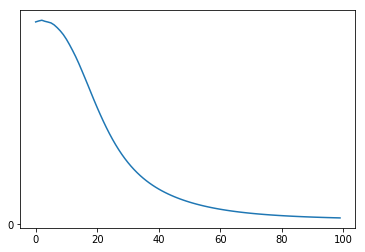

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=5)
ax.yaxis.set_major_locator(loc)
plt.plot(losses)

Test the trained model

In [11]:
from text_classification.fast_text.predict import predict
TEST_SENTENCE = 'good morning!'

with torch.no_grad():
    scores = model([TEST_SENTENCE], True)
    print(scores.size())
    topk_scores, topk_idx = torch.topk(scores, 5)
    print(topk_scores)
    print(topk_idx)
#     print(topk_scores[0,0])
    print(classes[topk_idx[0,0].item()])

torch.Size([1, 1427])

1.00000e-02 *
  3.4912  1.8788  1.7297  1.6968  1.1691
[torch.DoubleTensor of size (1,5)]


   82  1302   377   127  1252
[torch.LongTensor of size (1,5)]

BabyGender - Unhappy
